In [1]:

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json
import random
import numpy as np
import os

c:\Users\nghoo\AppData\Local\anaconda3\envs\hallucination_llm_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
SAVE_DIR = "./model"
TEST_PATH = "../test.jsonl"
MAX_LEN = 256
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR)
model.to(device)
model.eval()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [5]:
label2id = {"no": 0, "extrinsic": 1, "intrinsic": 2}
id2label = {v: k for k, v in label2id.items()}

In [6]:
class JsonlDataset(Dataset):
    def __init__(self, path, tokenizer, max_len=256):
        self.samples = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                self.samples.append(json.loads(line))
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        # Ghép message thành text
        text = " ".join([m["content"] for m in sample["messages"]])
        label = label2id[sample["label"]]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label)
        }

In [7]:
test_dataset = JsonlDataset(TEST_PATH, tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_batch = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

print("===== Classification Report =====")
print(classification_report(all_labels, all_preds, target_names=list(label2id.keys()), digits=4))

===== Classification Report =====
              precision    recall  f1-score   support

          no     0.0000    0.0000    0.0000         7
   extrinsic     0.3500    1.0000    0.5185         7
   intrinsic     0.0000    0.0000    0.0000         6

    accuracy                         0.3500        20
   macro avg     0.1167    0.3333    0.1728        20
weighted avg     0.1225    0.3500    0.1815        20



c:\Users\nghoo\AppData\Local\anaconda3\envs\hallucination_llm_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nghoo\AppData\Local\anaconda3\envs\hallucination_llm_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nghoo\AppData\Local\anaconda3\envs\hallucination_llm_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

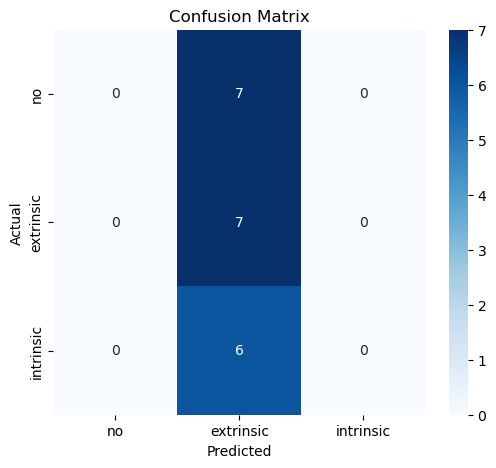

In [9]:
cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label2id.keys()),
            yticklabels=list(label2id.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()